# Collaborative Topic Modeling in Python
*by Mario Damiano Russo*


In this notebook, we will implement **Collaborative Topic Modeling** as introduced in the 2011 paper by Wang and Blei “Collaborative topic modeling for recommending scientific articles”.

We will use the model to build a scalable recommender system for steam Games, using two open-source, freely accessible datasets:
- Steam 200k, containing information about per-game playtime for over 200k user-game interactions: https://www.kaggle.com/tamber/steam-video-games/version/1.
- Steam games complete dataset, containing various information for over 40k different Steam games, including title and description: https://www.kaggle.com/trolukovich/steam-games-complete-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
from nltk.corpus import stopwords

from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary

import multiprocessing
import spacy
from nltk.corpus import stopwords

from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary

import multiprocessing

from sklearn.metrics import mean_squared_error
from tqdm import trange
import sys
import torch

In [4]:
# lowercase and apply special character removal to increase compatibility between titles
def lower_removedots(s):
    chars = ['!', ',', '.', '-', "'", '?', ":", "  "]
    for char in chars:
        s = s.replace(char, "")
    return s.lower()

games.name = games.name.apply(lambda x: lower_removedots(x))
ratings.Title = ratings.Title.apply(lambda x: lower_removedots(x))


titles_game = set(games.name.to_list())
titles_ratings = set(ratings.Title.to_list())

# save the list of titles for which we have both rating and description
intersection = titles_game.intersection(titles_ratings)

print(f"""Found {len(intersection)} titles for which we have both rating and description. 
Started with {len(titles_game)} in the games dataset and {len(titles_ratings)} in the ratings dataset.""")

Found 1991 titles for which we have both rating and description. 
Started with 37805 in the games dataset and 3600 in the ratings dataset.


In [5]:
# we now restrict both datasets based on our intersection
games = games[games.name.isin(intersection)]

# some games are duplicates / have the same name but different developer. Since its a few, we drop them altogether.
print(f"Found {games[games.name.duplicated()].shape[0]} duplicate entries in the games dataset.")
intersection = intersection.difference(set(games[games.name.duplicated()].name.to_list()))
games = games[games.name.isin(intersection)]
print(f"Found {games[games.name.duplicated()].shape[0]} duplicate entries in the games dataset.")


# the ratings dataset does not have duplicate item problems, so we just drop the titles we dropped in the games dataset.
ratings = ratings[ratings.Title.isin(intersection)]

# check to see that both datasets contain the same games.
try:
    assert len(set(ratings.Title.to_list())) == games.shape[0]
    print("Dataset game entries match.")
except AssertionError:
    raise Exception("Dataset game entries differ.")

Found 9 duplicate entries in the games dataset.
Found 0 duplicate entries in the games dataset.
Dataset game entries match.


# Creating the Ratings Matrix

In [6]:
R = pd.pivot_table(data=ratings, values = ["Value"], index=["UserID"], columns=["Title"])

# remove the level on top of game names called "Value"
R.columns = R.columns.droplevel()

# remove leftover columns name from pivot operation
R.columns.name = ""

# lastly, fill in the NaNs with 0's
R.fillna(0, inplace=True)

R.head(3)

,1 2 3 kick it (drop that beat like an ugly baby),10 second ninja,100% orange juice,10000000,12 labours of hercules ii the cretan bull,12 labours of hercules iii girl power,140,16bit trader,18 wheels of steel american long haul,3 stars of destiny,...,ziggurat,zombi,zombie army trilogy,zombie grinder,zombie panic source,zombie shooter 2,zombie zoeds,zoombinis,zuma deluxe,zumas revenge
UserID,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
R.shape

(10058, 1982)

In [6]:
animes_R_warm=pd.read_csv("/Users/shiningsunnyday/Desktop/anime/data/anime/train_val_test/10000/10000_warm_pref_matrix_train_0.csv",index_col=0)

animes_R_warm_val=pd.read_csv("/Users/shiningsunnyday/Desktop/anime/data/anime/train_val_test/10000/10000_warm_pref_matrix_test_0.csv",index_col=0)

animes_R_cold=pd.read_csv("/Users/shiningsunnyday/Desktop/anime/data/anime/train_val_test/10000/10000_val_pref_matrix.csv",index_col=0)

# Vanilla Matrix Factorization
We set a benchmark against which to compare CTM by implementing traditional Probabilistic Matrix Factorization.

In [3]:
# train - test split

def train_test_split(ratings, percs = [0.8, 0.2]):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        val_ratings = np.random.choice(ratings[user,:].nonzero()[0],
                                        size = round(len(ratings[user,:].nonzero()[0]) * percs[1]),
                                        replace=False
                                        )
        train[user, val_ratings] = 0
        validation[user, val_ratings] = ratings[user, val_ratings]
    
    return train, validation


train, val = animes_R_warm.values, animes_R_warm_val.values
print(f"""Train-test split exectuted.
      Train: {round(len(train.flatten().nonzero()[0]) / len(r.flatten().nonzero()[0]) * 100, 2)}% 
      Test: {round(len(val.flatten().nonzero()[0]) / len(r.flatten().nonzero()[0]) * 100, 2)}% """)


NameError: name 'r' is not defined

In [ ]:
animes_R_warm.shape, animes_R_warm_val.shape

((12767, 9000), (12767, 9000))

In [11]:

def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [16]:


class Recommender():
    def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.01, learning_rate=0.001):
        self.n_epochs = n_epochs
        self.n_latent_features = n_latent_features
        self.lmbda = lmbda
        self.learning_rate = learning_rate
    
    def predictions(self, P, Q):
        """
        returns dot product between:
            P = vector of preferences for user u / matrix of preferences
            Q = vector of qualities for item i / matrix of qualities
        """
        return np.dot(P.T, Q)
    
    def fit(self, X_train, X_val):
        # U = #users, I = #items
        U, I = X_train.shape
        
        # random initialization
        # get n_latent_features preference vectors of length U
        # get n_latent_features qualities vectors of length I
        # multiply both by 5 but any integer can go.
        self.P = 5 * np.random.rand(self.n_latent_features, U)
        self.Q = 5 * np.random.rand(self.n_latent_features, I)
        
        self.train_error = []
        self.val_error = []
        
        # store the indices combinations (u, i) that are nonzero
        users, items = X_train.nonzero()
        
        for iteration in trange(self.n_epochs, file=sys.stdout, desc='MF'):
            for u, i in zip(users, items):
                # compute the prediction error for the given cell (u, i)
                error = X_train[u, i] - self.predictions(self.P[:, u], self.Q[:, i])
                # update the vector of preferences for user u by considering the prediction error in (u, i)
                self.P[:, u] += self.learning_rate * (self.Q[:, i] * error - self.lmbda * self.P[:, u])
                # update the vector of preferences for item i by considering the prediction error in (u, i)
                self.Q[:, i] += self.learning_rate * (self.P[:, u] * error - self.lmbda * self.Q[:, i])
            self.train_error.append(mse(self.predictions(self.P, self.Q), X_train))
            self.val_error.append(mse(self.predictions(self.P, self.Q), X_val))
        
        return self
    
    def predict(self, X_train, user_index):
        # obtain the matrix of predicted ratings for all users and all items
        y_hat = self.predictions(self.P, self.Q)
        # then return the INDICES of the items for which there was no prediction for user u in the TRAINING SET
        predictions_index = np.where(X_train[user_index, :] == 0)[0]
        # return the predictions of the ratings that user u would give to the unrated elements.
        return y_hat[user_index, predictions_index].flatten()

In [18]:
recommender = Recommender(n_epochs=200, n_latent_features=3, lmbda=0.8).fit(animes_R_warm.values, animes_R_warm_val.values)

print(f"""Training done. 
        Train error: {recommender.train_error[-1]}
        Validation error: {recommender.val_error[-1]}""")

MF:   0%|          | 1/200 [00:21<1:12:40, 21.91s/it]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(recommender.train_error[2:], label = "train_error")
ax.plot(recommender.val_error[2:], label = "val_error")
ax.set_title("Probabilistic Matrix Factorization")
ax.set_ylabel("MSE")
ax.set_xlabel("Epochs")
ax.legend();

# Topic Modeling with LDA

Since lemmatization can take some time, the preprocessed dataset with the lemmatized game description is included in the folder. For reference, here is the code that was used to produce it:

```python
nlp = spacy.load("en")

# lemmatize game descriptions
games["lemmas"] = [[[token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() 
                     for token in sentence if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"}]
                    for sentence in nlp(speech).sents] for speech in games.game_description]
games.to_pickle("steam_games_preprocessed.pkl")
```

In [2]:
animes = pd.read_pickle("animes_preprocessed.pkl")
animes_val = pd.read_pickle("animes_preprocessed_val.pkl")

In [3]:
animes_train = pd.read_csv("/Users/shiningsunnyday/Desktop/anime/data/anime/train_val_test/10000/10000_animes_train_.csv",index_col=0)
animes_val = pd.read_csv("/Users/shiningsunnyday/Desktop/anime/data/anime/train_val_test/10000/10000_animes_val_.csv")
animes_warm = pd.read_csv("/Users/shiningsunnyday/Desktop/anime/data/anime/train_val_test/10000/10000_animes_warm_.csv")

animes_val.shape

(1000, 9)

In [25]:
animes_description = pd.Series([str(x) for (x,y) in zip(animes_warm.synopsis, animes_warm.reviews)])

nlp = spacy.load("en_core_web_sm")

# lemmatize game descriptions
animes = pd.Series({"description":animes_description,"lemmas":animes_description})
animes["lemmas"] = [[[token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() 
                     for token in sentence if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV", "X"}]
                    for sentence in nlp(speech).sents] for speech in animes_description]
animes.to_pickle("animes_preprocessed_synopsis.pkl")

In [4]:
animes = pd.read_pickle("animes_preprocessed_synopsis.pkl")
animes_val = pd.read_pickle("animes_preprocessed_val_synopsis.pkl")

# %%
instances_val = [[lemma for lemmatized_sentence in lemmatized_speech for lemma in lemmatized_sentence]
             for lemmatized_speech in animes_val.lemmas]

# %%
instances = [[lemma for lemmatized_sentence in lemmatized_speech for lemma in lemmatized_sentence]
             for lemmatized_speech in animes.lemmas]

dictionary = Dictionary(instances)

dictionary.filter_extremes(no_below = 5, no_above = 0.7)
print(dictionary)

# %%
ldacorpus = [dictionary.doc2bow(text) for text in instances]
ldacorpus_val = [dictionary.doc2bow(text) for text in instances_val]

num_topics = 100
num_passes = 30
chunk_size = len(ldacorpus) * num_passes/200




Dictionary(5349 unique tokens: ['[', 'able', 'act', 'again', 'alchemist']...)


In [5]:

model = LdaMulticore(num_topics=num_topics,
                    corpus=ldacorpus,
                    id2word=dictionary,
                    workers=multiprocessing.cpu_count()-1,
                    chunksize=chunk_size,
                    passes=num_passes,
                    alpha=0.1)

# %%
val_topics = model[ldacorpus_val]

# %%
train_topics = model.get_document_topics(ldacorpus, per_word_topics=True, minimum_probability=0.0)
val_topics = model.get_document_topics(ldacorpus_val, per_word_topics=True, minimum_probability=0.0)

def get_corpus_topics(all_topics):
    corpus_topics = []  

    for doc_topics, word_topics, phi_values in all_topics:
        corpus_topics.append([topic[1] for topic in doc_topics])
        
    corpus_topics = np.array(corpus_topics)
    return corpus_topics

# %%
# %%

corpus_topics = get_corpus_topics(train_topics)
val_corpus_topics = get_corpus_topics(val_topics)


# %%
words = [model.print_topics(num_topics=num_topics, num_words=5)[topic][1].split('\"')[1::2] for topic in range(num_topics)]

words_per_topic = dict(zip(range(num_topics), words))

# %%
# WE REMOVE THE LATENT VECTOR OF THE HELDOUT GAME 
theta = corpus_topics.copy().T

thet = pd.DataFrame(theta)
# heldout_topics = thet.iloc[:, heldout_idx]
# thet.drop(heldout_idx, axis = 1, inplace=True)
theta = thet.values

# %% [markdown]
# # Collaborative Topic Modeling

# %%
# WE REMOVE THE LATENT VECTOR OF THE HELDOUT GAME 
theta_val = val_corpus_topics.copy().T

thet_val = pd.DataFrame(theta_val)
# heldout_topics = thet.iloc[:, heldout_idx]
# thet.drop(heldout_idx, axis = 1, inplace=True)
theta_val = thet_val.values



NameError: name 'animes_R_warm' is not defined

In [18]:
# %%
X_train = animes_R_warm.copy()
X_val = animes_R_warm_val.copy()

# %%
from tqdm import trange
import sys

def user_recall_at_M(M, R_hat_np, val_pref_matrix,guess=False):
    ranking = np.argsort(-R_hat_np, axis=1)    
    if guess: ranking=np.random.rand(*ranking.shape)
    topM = ranking[:,:M]

    pref = val_pref_matrix.to_numpy()

    n = np.array([np.count_nonzero(topM[pref[:,i] > 0] == i) for i in range(pref.shape[1])])
    d = np.sum(pref > 0, axis=0)
    
    return np.mean(n[d>0] / d[d>0])


    
theta_val.shape


(100, 1000)

In [21]:
import torch 
class CTM():
    """
    Collaborative Topic Modeling Model as developed by Wang and Blei (2012).
    Leverages topic proportions obtained from LDA model to improve predictions
    and allow for out-of-matrix predictions.
    
    Parameters:
        - sigma2: expected variance of ratings 
                  (variance of the ratings Normal prior)
        - sigma2_P: expected variance of the elements of the
                    preference vector
        - sigma2_Q: expected variance of the elements of the
                    quality vector
    """
    def __init__(self, epochs=200, learning_rate=0.001, sigma2=10, sigma2_P=10, sigma2_Q=10):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.sigma2 = sigma2
        self.sigma2_P = sigma2_P
        self.sigma2_Q = sigma2_Q
    
    
    def fit(self, theta, X_train, X_val, X_out):
        """
        Fit a CTM model.
        
        Parameters:
            - theta: (K X I) matrix of topic proportions obtained via LDA.
            - X_train: (U X I) ratings matrix to train the model on.
            - X_test: (U X I) ratings matrix to validate the model on.
        """
        
        K = theta.shape[0]
        U, I = X_train.shape
        
        #initialize P and Q matrices.
        # P is initialized randomly
        self.P = np.random.randint(0, 10) * np.random.rand(K, U)
        # Q is initialized to be equal to theta
        self.Q = theta.copy()
        
        self.train_error = []
        self.val_error = []
        self.train_recalls = []
        self.cold_train_recalls = []
        
        # obtain the pairs of (u, i) indices for which we observe a rating
        users, items = X_train.nonzero()

        theta_val, animes_R_cold = X_out
        
        
        
        # begin training
        for iteration in trange(self.epochs, file=sys.stdout, desc='CTM'):
            for u, i in zip(users, items):
                error = X_train[u, i] - np.dot(self.P[:, u].T, self.Q[:, i])

                # we are MAXIMIZING the likelihood via gradient ascent
                self.P[:, u] += self.learning_rate * (-self.P[:, u]/self.sigma2_P + (self.P[:, u] * error) * self.sigma2)
                self.Q[:, i] += self.learning_rate * (-(self.Q[:, i] - theta[:, i])/self.sigma2_Q + (self.Q[:, i] * error) * self.sigma2)

            self.train_error.append(mse(np.dot(self.P.T, self.Q), X_train))
            self.val_error.append(mse(np.dot(self.P.T, self.Q), X_val))
            self.train_recalls.append(user_recall_at_M(100,self.predict_ratings(), animes_R_warm_val))            
            self.cold_train_recalls.append(user_recall_at_M(100,self.predict_out_of_matrix(theta_val),animes_R_cold))
            warm_base = user_recall_at_M(100,torch.rand_like(torch.FloatTensor(self.predict_ratings())), animes_R_warm_val)
            cold_base = user_recall_at_M(100,torch.rand_like(torch.FloatTensor(ctm.predict_out_of_matrix(theta_val))),animes_R_cold)
            print("warm baseline from guessing:", warm_base)
            print("cold baseline from guessing:", cold_base)
            print(f"iter {iteration}, warm train recall {self.train_recalls[-1]}")
            print(f"iter {iteration}, cold train recall {self.cold_train_recalls[-1]}")
    
    
    
    def predict_ratings(self):
        """
        Returns the matrix of predicted ratings.
        """
        return np.dot(self.P.T, self.Q)
    
    
    
    def predict_out_of_matrix(self, topics):
        """
        Returns the (U X 1) vector of predicted ratings 
        for an unrated item, using the item's topic proportions.
        
        Parameters:
            - topics: (K X 1) array of topic proportions
                      for the unrated item.
        """
        return np.dot(self.P.T, topics)

# %%
ctm = CTM(epochs=200, sigma2_P=5, sigma2_Q=5, sigma2=1)
ctm.fit(theta, X_train.values, X_val.values, (theta_val, animes_R_cold))

print(f"""Training done. 
        Train error: {ctm.train_error[-1]}
        Validation error: {ctm.val_error[-1]}""")

CTM:   0%|          | 0/200 [00:00<?, ?it/s]warm baseline from guessing: 0.011336657419735769
cold baseline from guessing: 0.10779916958663804
iter 0, warm train recall 0.0275880629958033
iter 0, cold train recall 0.12222431444791682
CTM:   0%|          | 1/200 [00:34<1:55:17, 34.76s/it]warm baseline from guessing: 0.010008453541513139
cold baseline from guessing: 0.10808150415619396
iter 1, warm train recall 0.027537485577885164
iter 1, cold train recall 0.12222431444791682
CTM:   1%|          | 2/200 [01:08<1:53:32, 34.41s/it]warm baseline from guessing: 0.010476764522182743
cold baseline from guessing: 0.10198824756148589
iter 2, warm train recall 0.027428367048227344
iter 2, cold train recall 0.12222431444791682
CTM:   2%|▏         | 3/200 [01:42<1:52:11, 34.17s/it]warm baseline from guessing: 0.012200730491590515
cold baseline from guessing: 0.09395166735244578
iter 3, warm train recall 0.02739932845133853
iter 3, cold train recall 0.12222431444791682
CTM:   2%|▏         | 4/200 [

# Collaborative Topic Modeling

X_val.shape

In [86]:
user_recall_at_M(100,ctm.predict_out_of_matrix(theta_val),animes_R_cold)

0.09194051155681729

In [78]:
avg=[]
for _ in range(10):
    rec = user_recall_at_M(100,torch.rand_like(torch.FloatTensor(ctm.predict_out_of_matrix(theta_val))),animes_R_cold)
    # rec = torch.rand_like(torch.FloatTensor(ctm.predict_ratings())
    avg.append(rec)
    print(sum(avg)/len(avg))



0.10610648297838218
0.10058487672496103
0.09913568497285058
0.09867652912072833
0.09933361826917567
0.09943889114551784
0.10146899367866073
0.10185797447545944
0.10278698461467235
0.10271661363526838


In [55]:


avg=[]
for _ in range(10):
    avg.append(user_recall_at_M(100,torch.rand_like(torch.FloatTensor(ctm.predict_ratings())),X_val))
    print(sum(avg)/len(avg))

0.009289169012156172
0.010316099927341501
0.010751920998255879
0.010952225073921618
0.01107798084220692
0.0110243750499455
0.011026810411240111
0.0111106974436567
0.011183822222612518
0.01135459670090273


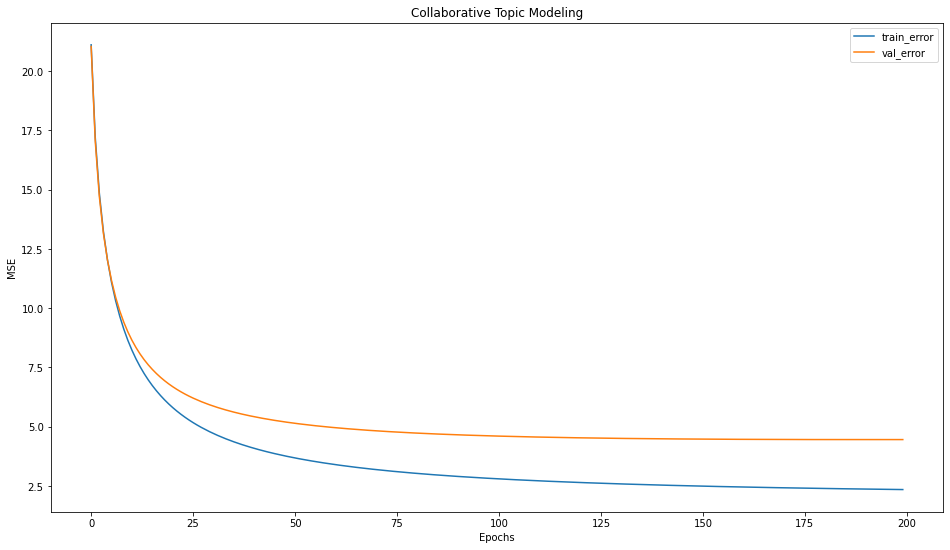

In [48]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(ctm.train_error, label = "train_error")
ax.plot(ctm.val_error, label = "val_error")
ax.set_title("Collaborative Topic Modeling")
ax.set_ylabel("MSE")
ax.set_xlabel("Epochs")
ax.legend();

In [25]:
# out-of-matrix prediction

heldout_predicted = np.dot(ctm.P.T, heldout_topics.values)

print(f"MSE for the heldout game - {heldout_name}:")
print(mse(heldout_predicted, heldout_ratings.values))

MSE for the heldout game - need for speed undercover:
0.29237484645396145


## Additional analyses
We can also study per-item topic relevances

In [26]:
gamename = "halflife"

# find the index number of halflife
for i, t in enumerate(R.columns):
    if t == gamename:
        idx = i
        break
        
print(f"Topic relevances for {gamename}:")        
for i, mixture in enumerate(ctm.Q[:, idx]):
    print(f"\t{round(mixture * 100, 2)}: {words_per_topic[i]}")

Topic relevances for halflife:
	28.71: ['new', 'player', 'world', 'level', 'can']
	0.37: ['vampire', 'rid', 'virus', 'slice', 'practice']
	0.37: ['ambient', 'logic', 'skull', 'pc', 'puzzle']
	0.37: ['mechanism', 'slave', 'drift', 'quad', 'penguin']
	0.84: ['fuel', 'roster', 'league', 'swap', 'bury']
	0.37: ['vassal', 'pour', 'dreamlike', 'manor', 'scour']
	0.37: ['wreck', 'writing', 'rig', 'dwell', 'deepen']
	5.59: ['zombie', 'car', 'soul', 'lie', 'final']
	0.37: ['minimal', 'subtle', 'dad', 'espionage', 'shower']
	2.83: ['subterranean', 'bubble', 'shark', 'vector', 'anomaly']
	0.37: ['shocking', 'offspring', 'commodity', 'smell', 'manic']
	0.37: ['orc', 'mercy', 'multipli', 'lively', 'manga']
	0.37: ['wizard', 'stick', 'humor', 'franchise', 'cell']
	0.37: ['restaurant', 'pedestrian', 'garbage', 'idle', 'd']
	0.37: ['heist', 'performer', 'overarch', 'catchy', 'diehard']


# Further investigation - which genres are most popular?

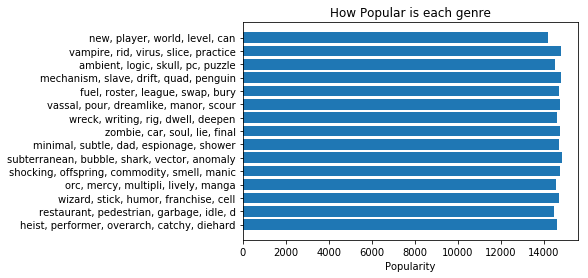

In [27]:
fig, ax = plt.subplots()

# Example data
labels = list(words_per_topic.values())
performance = ctm.P.sum(axis=1)

ax.barh([", ".join(l) for l in labels], performance, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularity')
ax.set_title('How Popular is each genre')

plt.show()

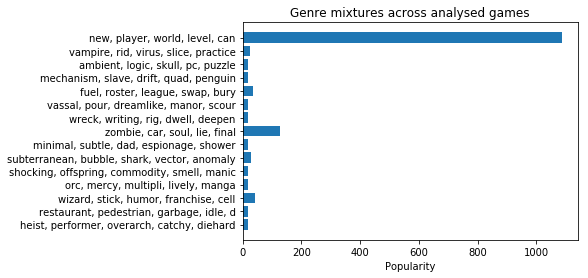

In [28]:
fig, ax = plt.subplots()

# Example data
labels = list(words_per_topic.values())
performance = ctm.Q.sum(axis=1)

ax.barh([", ".join(l) for l in labels], performance, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularity')
ax.set_title('Genre mixtures across analysed games')

plt.show()